# Cervical Cancer Classification Model

In [82]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [83]:
!pwd

/content


In [84]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [85]:
!mkdir imageclassifier

mkdir: cannot create directory ‘imageclassifier’: File exists


# 1. Install Dependencies and Setup

In [86]:
!pip install tensorflow tensorflow

In [87]:
import tensorflow as tf
import os

In [88]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [89]:
os.listdir('data')

[]

In [90]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove Dodgy Images

In [91]:
!pip install flask-ngrok
!pip install tensorflow

In [92]:
import cv2
import imghdr

In [93]:
data_dir = 'data'

In [94]:
image_exts = ['jpeg', 'jpg', 'bmp']

In [95]:

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

        # Check if the path is a file before processing
        if os.path.isfile(image_path):
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                os.remove(image_path)

# 3. Load Data

In [96]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/dataset1/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import numpy as np
from matplotlib import pyplot as plt

In [98]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/dataset1/')

Found 4014 files belonging to 2 classes.


In [99]:
data_iterator = data.as_numpy_iterator()

In [100]:
batch = data_iterator.next()

In [101]:
len(batch)

2

In [102]:
batch[1]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1], dtype=int32)

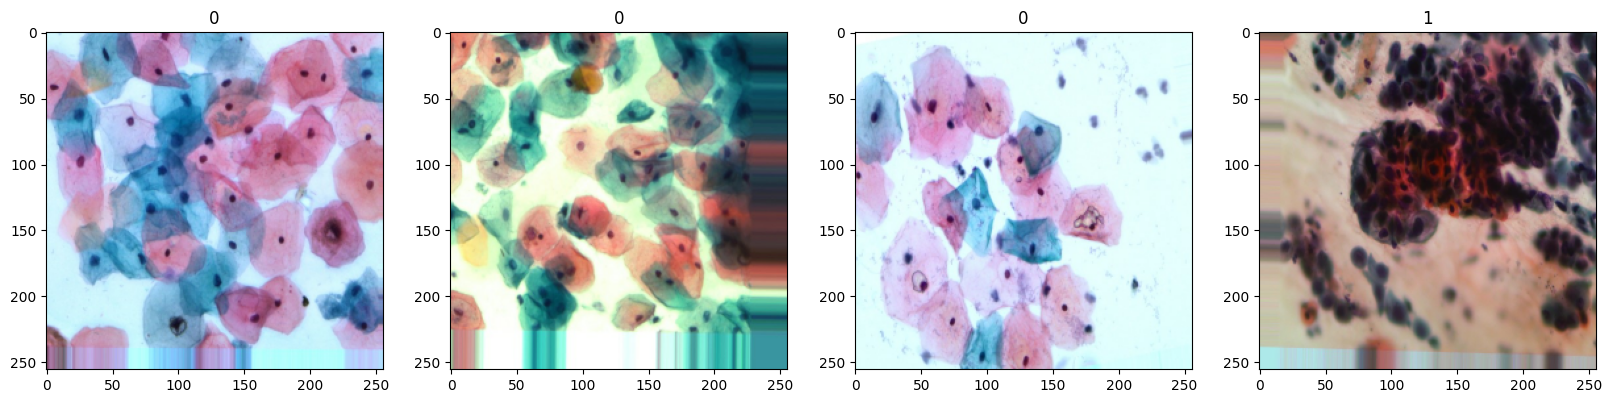

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [104]:
data = data.map(lambda x,y: (x/255, y))

In [105]:
data.as_numpy_iterator().next()

(array([[[[0.82941175, 0.93921566, 0.81960785],
          [0.84117645, 0.9431372 , 0.7941176 ],
          [0.80196077, 0.9137255 , 0.7705882 ],
          ...,
          [0.7392157 , 0.8098039 , 0.8352941 ],
          [0.7392157 , 0.8098039 , 0.8352941 ],
          [0.7392157 , 0.8098039 , 0.8352941 ]],
 
         [[0.82941175, 0.93921566, 0.81960785],
          [0.84117645, 0.9431372 , 0.80196077],
          [0.8039216 , 0.91568625, 0.77254903],
          ...,
          [0.7392157 , 0.8245098 , 0.8352941 ],
          [0.7392157 , 0.8245098 , 0.8352941 ],
          [0.7392157 , 0.8245098 , 0.8352941 ]],
 
         [[0.827451  , 0.9352941 , 0.8235294 ],
          [0.84313726, 0.94509804, 0.8039216 ],
          [0.8039216 , 0.91568625, 0.78039217],
          ...,
          [0.7519608 , 0.827451  , 0.8333333 ],
          [0.7519608 , 0.827451  , 0.8333333 ],
          [0.7519608 , 0.827451  , 0.8333333 ]],
 
         ...,
 
         [[0.74509805, 0.84705883, 0.8352941 ],
          [0.74509

# 5. Split Data

In [106]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [107]:
train_size

88

In [108]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [109]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [111]:
model = Sequential()

In [112]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [113]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [114]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [115]:
logdir = 'logs'

In [116]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of monitored quantity
)


In [117]:
import tensorflow as tf

def load_image(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        return img
    except tf.errors.InvalidArgumentError:
        print(f"Skipping invalid image: {image_path}")
        return None  # or handle the invalid image case

In [118]:
 hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6935 - loss: 0.6487 - val_accuracy: 0.8863 - val_loss: 0.3001
Epoch 2/20
42/88 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.9049 - loss: 0.2626

KeyboardInterrupt: 

In [ ]:
hist.history

# 8. Plot Performance

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Plotting
fig = plt.figure()

# Plotting accuracy vs loss
plt.plot(accuracy, loss, color='teal', label='Train Loss vs Accuracy')
plt.plot(val_accuracy, val_loss, color='orange', label='Val Loss vs Val Accuracy')

fig.suptitle('Loss vs Accuracy', fontsize=20)
plt.xlabel('Accuracy')
plt.ylabel('Loss')

plt.legend(loc="upper right")
plt.show()


# 9. Evaluate

In [126]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [127]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [128]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [129]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.94210523, shape=(), dtype=float32) tf.Tensor(0.9713542, shape=(), dtype=float32)


# 10. Test

In [ ]:
import cv2

In [ ]:
img = cv2.imread('unhealthyTest.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat <= 0.4:
    print(f'Predicted class is healthy')
else:
    print(f'Predicted class is unhealthy')

# 11.Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/MyDrive/imageclassifier.h5')


# 12.Server

In [1]:
!pip install pyngrok


In [2]:
!pip install flask-ngrok

In [3]:
!ngrok config add-authtoken 2nvqHYBGiiWidezr5p8MvVOWcHQ_53qebHGAtdDBXg1wTfpS9

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
!pip install flask_cors

In [ ]:
# Import necessary libraries
from flask import Flask, request, jsonify
import tensorflow as tf
from pyngrok import ngrok  # For exposing the app to the internet
import numpy as np
from PIL import Image
import io
from flask_cors import CORS
import os
from google.colab import drive  # For mounting Google Drive

# Mount Google Drive and load the pre-trained model
drive.mount('/content/drive')
model = tf.keras.models.load_model('/content/drive/MyDrive/imageclassifier.h5')  # Update this path as needed

# Initialize Flask app
app = Flask(__name__)
CORS(app)

# Define image preprocessing function (adjust it based on your model's input format)
def preprocess_image(image, target_size=(256, 256)):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize if needed
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

@app.route('/')
def home():
    return "Hello, Welcome"

@app.route('/hello')
def hello():
    return "Hello, Welcome"

# Define the API endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Check if an image file was uploaded
        if 'file' not in request.files:
            return jsonify({"error": "No file uploaded"}), 400

        # Read the uploaded image file
        file = request.files['file']
        image = Image.open(io.BytesIO(file.read()))

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Make prediction
        predictions = model.predict(processed_image)
        predicted_class = 1 if predictions[0][0] > 0.5 else 0  # Use a threshold

        # Return the prediction result as JSON
        print(f"Predictions: {predictions}, Predicted Class: {predicted_class}")
        return jsonify({'prediction': float(predicted_class)})

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    # Start the ngrok tunnel
    public_url = ngrok.connect(5000)  # Expose the Flask app via ngrok
    print(f"Public URL: {public_url}")  # This is your external access URL

    # Run the Flask app
    app.run()


Mounted at /content/drive


Public URL: NgrokTunnel: "https://d64c-35-243-215-167.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:16:26] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99982744]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:16:37] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99998933]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:16:53] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.4757933e-09]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:17:00] "POST /predict HTTP/1.1" 200 -


Predictions: [[9.105185e-05]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:17:09] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.00216628]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:17:24] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.00048401]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:17:57] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.9478534]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:08] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.13483244]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:16] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.03631031]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:25] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:33] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.41305113]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:42] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:52] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:18:59] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.9478534]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:19:07] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99100703]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:19:18] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:19:27] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.91852915]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:31:30] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99982744]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:31:39] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:31:48] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99976164]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:31:56] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.99998933]], Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:12] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.01734331]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:17] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.1690981e-08]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:25] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.7794743e-07]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:34] "POST /predict HTTP/1.1" 200 -


Predictions: [[9.105185e-05]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:43] "POST /predict HTTP/1.1" 200 -


Predictions: [[0.00216628]], Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [28/Oct/2024 13:32:53] "POST /predict HTTP/1.1" 200 -


Predictions: [[1.6409566e-06]], Predicted Class: 0
